Poniżej zaprezentowano testy filtru o skończonej odpowiedzi impulsowej przygotowanego w ramach zajęć PBL w 2026 roku.
Ta część testów dotyczy wizualizacji zaprojektowanego filtru. W tym celu przygotowano:

*   wykres odpowiedzi impulsowej (test 6 test_fir.py),
*   wykres odpowiedzi filtru na sinusoidę (test 7 test_fir.py),
*   wykres charakterystyki amplitudowej i fazowej,
*   obliczenia opóznienia pomiedzy dwoma filtrami oraz opóźnienia grupowego (test 2 test_fir.py),
*   wykres przedstawiajacy mozliwe róznice wyników filtru FIR projektu oraz filtru złotego modelu `ModelFIR/model_fir.py` (testy 1,2,3,4,5 test_fir.py).




---



Analizowany filtr FIR działa zgodnie z ponizszym wzorem:

$y[n]$=$\sum_{k=0}^{M−1}$$​coeffs[k]⋅x[n−k]$

Gdzie:

$x[n]$ – próbki wejściowe,

$coeffs[k]$ – współczynniki,

$M$ – liczba tapów, współczynników,

$y[n]$ – próbki wyjściowe.



---



Fixed-point 16-bit signed, 2’s complement:

Dane wejściowe, współczynniki filtra i dane wyjściowe są z zakresu -32768 … +32767, dodatkowo docelowo są w formacie Q1.15.

W formacie Q1.15 bit MSB jest bitem znaku, następne 15 bitów jest część ułamkową, w wyniku również otrzymujemy 15 bitów przesuwając uzyskany wektor w prawo o 15 bitów.



---



In [1]:
import numpy as np
import matplotlib.pyplot as plt

Kod złotego modelu `ModelFIR/model_fir.py` filtru FIR z projektu:

In [2]:
# =========================
# Fixed-point helpers
# =========================

def sat_signed(val, bits):
    min_v = -(1 << (bits - 1))
    max_v = (1 << (bits - 1)) - 1
    return max(min(val, max_v), min_v)

def to_int16(val):
    return sat_signed(val, 16)

def to_int21(val):
    return sat_signed(val, 21)

# =========================
# FIR HW-accurate model
# =========================

def fir_hw_model(samples, coeffs, ile_probek, ile_wsp):
    """
    samples, coeffs: list[int]  -> int16 Q1.15
    return: list[int]           -> int16 Q1.15
    """

    out = []

    for n in range(ile_probek + ile_wsp - 1):
        acc = 0  # 21-bit accumulator (Q1.15)

        for k in range(ile_wsp):
            x_idx = n - k
            if 0 <= x_idx < ile_probek:

                # 16b x 16b -> 31b signed
                prod = samples[x_idx] * coeffs[k]

                # wybór bitów [30:15] -> Q1.15
                mul_q15 = prod >> 15

                # akumulacja (21 bit)
                acc += mul_q15
                acc = to_int21(acc)

        # wyjście: 21b -> 16b Q1.15
        y = to_int16(acc)
        out.append(y)

    return out

FIR: przykładowe współczynniki:

In [3]:
# coeffs = [16384, 16384]  # 0.5 + 0.5 w Q1.15
# coeffs = [10923, 10923, 10921]  # ~0.333 + 0.333 + 0.333 w Q1.15
coeffs = [8192, 16384, 24576]  # 0.25, 0.5, 0.75 w Q1.15
# coeffs = [8192, 16384, 16384, 8192]  # 0.25, 0.5, 0.5, 0.25 w Q1.15

#Odpowiedź impulsowa

Odpowiedź impulsowa filtru to sygnał wyjściowy układu filtra pobudzonego impulsem jednostkowym w dziedzinie czasu.
Dla filtrów FIR odpowiedź impulsowa dla impulsów o skończonej długości jest skończona, to znaczy reakcja na impuls zanika w skończonym czasie. Co więcej odpowiedź impulsowa dla filtrów FIR będzie przedstawiać ciąg współczynników filtra. Jest to bezpośrednio związane z definicją transmitancji tych filtrów.

In [14]:
impulse = [32767] + [0]*15 # impuls jednostkowy, wartość 1 dla pierwszej próbki sygnału i 0 dla reszty próbek

ile_probek = len(impulse)
ile_wsp = len(coeffs)

In [15]:
ile_probek + ile_wsp - 1

18

In [16]:
coeffs

[8192, 16384, 24576]

In [17]:
y_out = fir_hw_model(impulse, coeffs, ile_probek, ile_wsp)

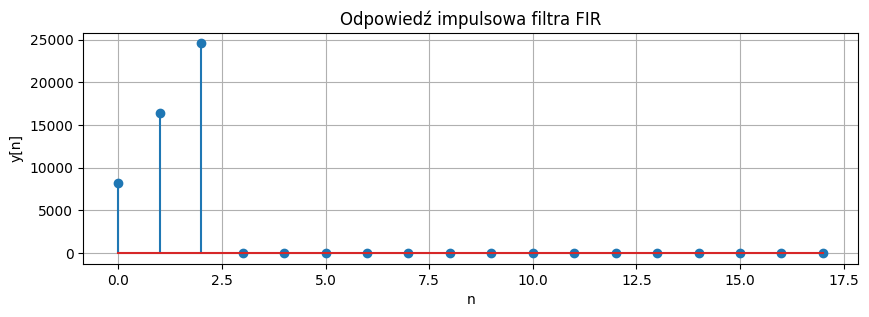

In [18]:
plt.figure(figsize=(10, 3))
plt.stem(y_out)
plt.title("Odpowiedź impulsowa filtra FIR")
plt.xlabel("n")
plt.ylabel("y[n]")
plt.grid(True)
plt.show()

## Test 1 - Odpowiedź impulsowa

Jeżeli na wejście podamy:

x[0] = 1

x[n>0] = 0

Wynik FIR powinien być równy:

y[n] = [coeffs[0], ... , coeffs[k]]

Jest to Test 6 w test_fir.py.

# Odpowiedź filtru na sinus

Poniżej przedstawiono odpowiedź analizowanego filtru na sygnał sinusoidy.

In [9]:
N = 32
f_sin = 5
t_out = np.arange(ile_probek + ile_wsp - 1)
t = np.arange(N)

In [10]:
sine_wave = np.round(32767 * np.sin(2*np.pi*f_sin*t/N)).astype(int)

ile_probek = len(sine_wave)
ile_wsp = len(coeffs)

In [11]:
ile_probek + ile_wsp - 1

34

In [12]:
y_sine_out = fir_hw_model(sine_wave, coeffs, ile_probek, ile_wsp)

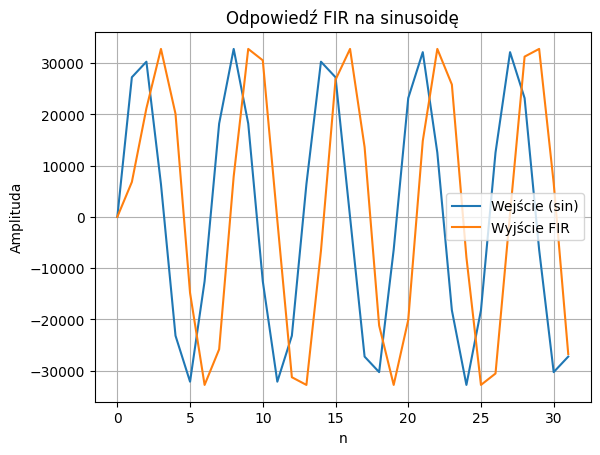

In [21]:
plt.figure()
plt.plot(t, sine_wave, label="Wejście (sin)")
plt.plot(t, y_sine_out[:N], label="Wyjście FIR")
plt.title("Odpowiedź FIR na sinusoidę")
plt.xlabel("n")
plt.ylabel("Amplituda")
plt.legend()
plt.grid(True)
plt.show()

## Test 2 - Odpowiedź na sinus

W tym wypadku przedstawiam odpowiedź na sinus tylko na wykresie.

Test 7 test_fir.py.

# Charakterystyka częstotliwościowa filtru

In [22]:
def frequency_response(coeffs):
    H = np.fft.fft(coeffs, 512) # zeros up to 512 for smoother digram
    H = H[:256]
    f = np.linspace(0, 1, 256) # frequency normalized 0..1
    w = np.linspace(0, 2*np.pi, len(H))

    return w, f, H

In [23]:
w, f, H = frequency_response(coeffs)

Charakterystyka amplitudowa:

Moduł transmitancji określa charakterystykę amplitudową, czyli wzmocnienie filtru dla poszczególnych zakresów częstotliwości.

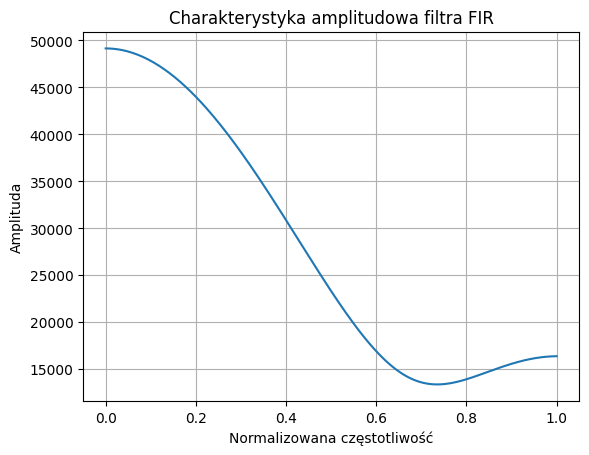

In [24]:
plt.plot(f, (np.abs(H)))
plt.title("Charakterystyka amplitudowa filtra FIR")
plt.xlabel("Normalizowana częstotliwość")
plt.ylabel("Amplituda")
plt.grid()
plt.show()

Charakterystyka fazowa:

Charakterystyka fazowa filtru przedstawia zależność przesunięcia fazowego sygnału wyjściowego względem wejściowego. Przedstawia ona, jak poszczególne składowe częstotliwościowe sygnału są opóźnione.

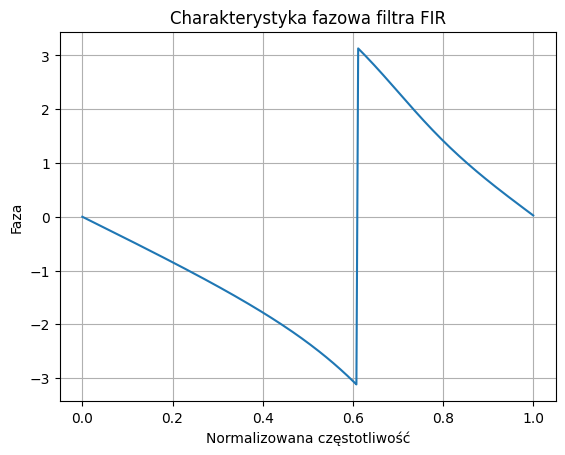

In [25]:
plt.plot(f, np.angle(H))
plt.title("Charakterystyka fazowa filtra FIR")
plt.xlabel("Normalizowana częstotliwość")
plt.ylabel("Faza")
plt.grid()
plt.show()

## Test 3 - Charakterystyka częstotliwościowa

Przedstawiam wykresy charakterystyk amplitudowej i fazowej. Na ich podstawie można zidentyfikować czy filtr jest górno-, czy dolnoprzepustowy oraz częstotliwości odcięcia filtra.

Dodatkowo jedną z cech charakterystycznych filtrów FIR o symetrycznej odpowiedzi impulsowej jest liniowa charakterystyka fazowa. Oznacza to stałe opóźnienie grupowe, czyli wszystkie składowe częstotliwościowe sygnału opóźnione o ten sam czas.

# Opóźnienie filtru

## Opóźnienie pomiedzy modelami filtrów FIR projektu oraz filtru ModelFIR/model_fir.py

Opóźnienie pomiędzy sygnałami wyjsciowymi obu filtrów.

coeffs2 i ile_wsp2 pojawiają się tutaj w celu symulacja róznicy między sygnałami 0 i 2.

In [26]:
coeffs2 = [10923, 10923, 10921]  # ~0.333 + 0.333 + 0.333 w Q1.15, współczynniki dla sygnału drugiego.

In [27]:
ile_probek = len(sine_wave)
ile_wsp = len(coeffs)
ile_wsp2 = len(coeffs2)

In [28]:
hw_output = fir_hw_model(sine_wave, coeffs, ile_probek, ile_wsp)
model_output = fir_hw_model(sine_wave, coeffs2, ile_probek, ile_wsp)

In [29]:
def compute_delay(hw_output, model_output):
  hw_output = np.array(hw_output)
  model_output = np.array(model_output)

  corr = np.correlate(hw_output, model_output, mode="full")
  delay = np.argmax(corr) - (len(model_output) - 1)

  return delay

In [30]:
deley = compute_delay(hw_output=hw_output, model_output=model_output)

In [31]:
deley

np.int64(0)

## Opóźnienie grupowe

Obliczenie opóźnienia grupowego nawet jeśli filtr nie ma liniowej charakterystyki fazowej.

In [32]:
# Kod dla filtrów FIR symetrycznych
# def compute_group_delay(coeffs):
  # w, f, H = frequency_response(coeffs)
  # phase = np.angle(H)
  # group_delay = -np.gradient(phase, w)

  # return group_delay

In [33]:
# group_delay = compute_group_delay(coeffs=coeffs2)

In [34]:
# group_delay

In [49]:
def compute_group_delay(coeffs, n_fft=2048):
    """
    coeffs : lista współczynników FIR (int lub float)
    n_fft  : rozdzielczość FFT
    plot   : czy rysować wykres

    Zwraca:
        w           - wektor częstotliwości (rad/sample)
        tau         - wektor opóźnienia grupowego
        tau_mean    - średnie opóźnienie w paśmie niskim
    """

    # FFT filtru
    H = np.fft.fft(coeffs, n_fft)
    H = H[:n_fft//2]

    # Oś częstotliwości
    w = np.linspace(0, np.pi, len(H))

    # Faza + unwrap
    phase = np.unwrap(np.angle(H))

    # Pochodna fazy
    tau = -np.gradient(phase, w)

    # Jedna wartość reprezentatywna:
    # średnia z pierwszych 10% pasma (bez DC = 0)
    low_band = tau[1:int(0.1 * len(tau))]
    tau_mean = np.mean(low_band)

    print(f"Średnie opóźnienie (niski zakres częstotliwości): {tau_mean:.4f} próbek")

    return w, tau, tau_mean

In [50]:
w, tau, tau_mean = compute_group_delay(coeffs)

Średnie opóźnienie (niski zakres częstotliwości): 1.3363 próbek


In [37]:
w

array([0.00000000e+00, 3.07096056e-03, 6.14192112e-03, ...,
       3.13545073e+00, 3.13852169e+00, 3.14159265e+00])

In [38]:
tau

array([1.33203166, 1.33203288, 1.33203653, ..., 1.99817853, 1.998108  ,
       1.99807979])

In [39]:
tau_mean

np.float64(1.3363022336326622)

## Test 4 - Przedstawienie wyników opóźnienia pomiedzy filtrami lub opóźnienia grupowego.

Test 2 test_fir.py.

# Odpowiedź na inne dane wejściowe

coeffs2 pojawia się tutaj w celu symulacji róznicy między sygnałami 0 i 2.

In [40]:
coeffs2 = [10923, 10923, 10921]  # ~0.333 + 0.333 + 0.333 w Q1.15

In [41]:
N = 32
f_sin = 5
# t_out = np.arange(ile_probek + ile_wsp - 1)
t = np.arange(N)
sine_wave = np.round(10000 * np.sin(2*np.pi*f_sin*t/N)).astype(int)  # Q1.15

In [42]:
ile_probek = len(sine_wave)
ile_wsp = len(coeffs)
ile_wsp2 = len(coeffs2)

In [43]:
hw_output = fir_hw_model(sine_wave, coeffs, ile_probek, ile_wsp)
model_output = fir_hw_model(sine_wave, coeffs2, ile_probek, ile_wsp)

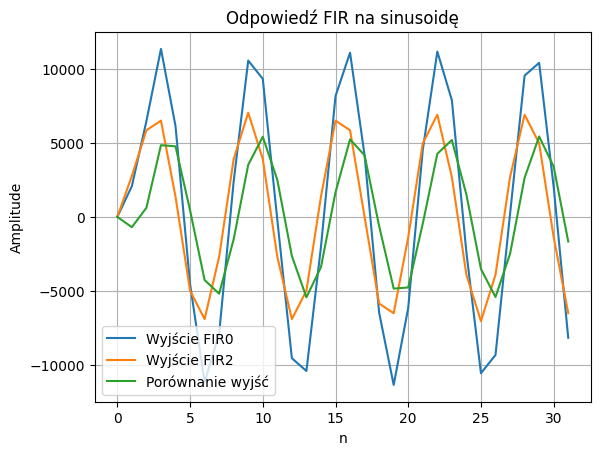

In [44]:
plt.figure()
#plt.plot(t, sine_wave, label="Wejście (sin)")
plt.plot(t, hw_output[:N], label="Wyjście FIR0")
plt.plot(t, model_output[:N], label="Wyjście FIR2")
plt.plot(t, np.array(hw_output[:N]) - np.array(model_output[:N]), label="Porównanie wyjść")
plt.title("Odpowiedź FIR na sinusoidę")
plt.xlabel("n")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

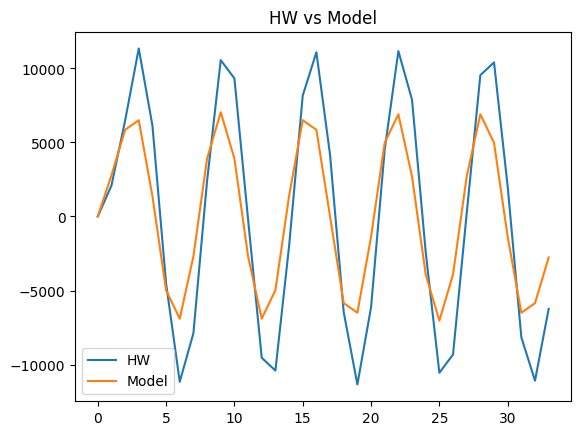

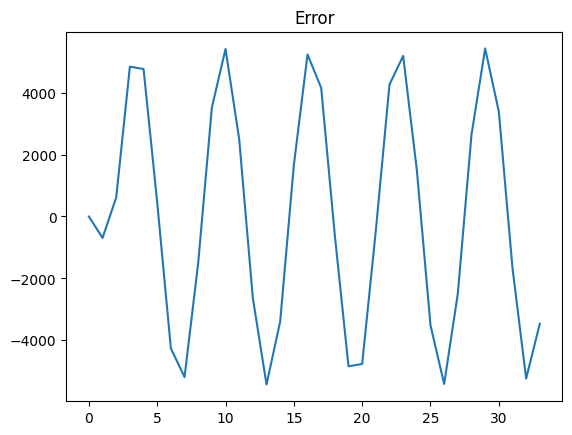

In [45]:
plt.plot(hw_output, label="HW")
plt.plot(model_output, label="Model")
plt.legend()
plt.title("HW vs Model")
plt.show()

error = np.array(hw_output) - np.array(model_output)
plt.plot(error)
plt.title("Error")
plt.show()

## Test 5 - Zamieszczenie na jednym wykresie sygnału wejściowego i sygnału wyjściowego poddanego filtracji.

Osobny wykres dla modelu filtru FIR projektu oraz filtru złotego modelu `ModelFIR/model_fir.py`.

Testy 1,2,3,4,5 test_fir.py

## Test 6 - Przedstawienie różnicy wyniku modelu filtru FIR projektu oraz filtru złotego modelu `ModelFIR/model_fir.py` na jednym wykresie.

Dla testów kiedy wystepuje różnica w wynikach.

Testy 1,2,3,4,5 test_fir.py.